# Import Libraries

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns

# Hypothesis Testing

sources:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistics/basic-statistics/supporting-topics/normality/what-to-do-with-nonnormal-data/
- https://stats.stackexchange.com/questions/5680/can-i-trust-anova-results-for-a-non-normally-distributed-dv
- https://stats.stackexchange.com/questions/283211/whitney-mann-u-test-i-e-wilcoxon-rank-sum-and-discrete-ordinal-data
- https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e
- https://www.statology.org/hypothesis-test-python/
- https://www.statology.org/mann-whitney-u-test-python/
- https://www.geeksforgeeks.org/how-to-conduct-a-wilcoxon-signed-rank-test-in-python/
- https://www.statology.org/kruskal-wallis-test-python/
- https://sixsigmadsi.com/wp-content/uploads/2018/07/Hypothesis-Testing-Roadmap-Continuous-Data.jpg


In [3]:
df = pd.read_csv('sample_sentiment.csv')

In [13]:
# checking mean per year
df.groupby('created_year')['Sentiment'].mean()

created_year
2017    1.511327
2018    1.508070
2019    1.478315
2020    1.518108
2021    1.545513
2022    1.523839
2023    1.546903
Name: Sentiment, dtype: float64

In [4]:
# random sampling 2_500 per period
n = 2_500

sentiment_score_pre_covid = random.sample(df[df['created_year'].isin([2017, 2018])]['Sentiment'].to_list(), n)
sentiment_score_covid = random.sample(df[df['created_year'].isin([2019, 2020, 2021])]['Sentiment'].to_list(), n)
sentiment_score_post_covid = random.sample(df[df['created_year'].isin([2022, 2023])]['Sentiment'].to_list(), n)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


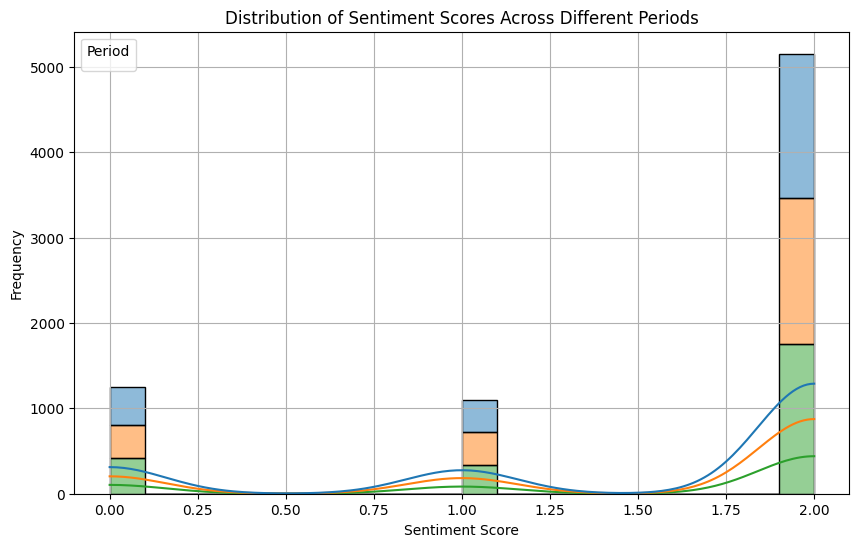

In [7]:
distribution_data = pd.DataFrame({
    'Sentiment': sentiment_score_pre_covid + sentiment_score_covid + sentiment_score_post_covid,
    'Period': ['Pre-COVID'] * n + ['COVID'] * n + ['Post-COVID'] * n
})

# data distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=distribution_data, x='Sentiment', hue='Period', multiple="stack", kde=True)
plt.title('Distribution of Sentiment Scores Across Different Periods')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(title='Period')
plt.grid(True)
plt.show()

## ANOVA

1. Defining Hypothesis

    H₀: μ₁=μ₂=μ₃ or The mean of the samples is the same.

    H₁: At least one of them is different.


2. Assumption Check

    H₀: The data is normally distributed.

    H₁: The data is not normally distributed.

    H₀: The variances of the samples are the same.

    H₁: The variances of the samples are different.

In [10]:
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

In [11]:
check_normality(sentiment_score_pre_covid)
check_normality(sentiment_score_covid)
check_normality(sentiment_score_post_covid)

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


In [12]:
stat, pvalue_levene= stats.levene(sentiment_score_pre_covid, sentiment_score_covid, sentiment_score_post_covid)
print("p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.3033
Fail to reject null hypothesis >> The variances of the samples are same.


In [22]:
F, p_value = stats.f_oneway(sentiment_score_pre_covid, sentiment_score_covid, sentiment_score_post_covid)
print("p value:%.6f" % p_value)
if p_value <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.303287
Fail to reject null hypothesis


ANOVA should not be used if sample distribution is not normal.

## Paired T-test

A paired samples t-test is used to compare the means of two samples when each observation in one sample can be paired with an observation in the other sample.

In [8]:
# t-test pre_covid and covid
stats.ttest_rel(a=sentiment_score_pre_covid, b=sentiment_score_covid)

TtestResult(statistic=-0.5931262902171017, pvalue=0.5531503096907817, df=2499)

In [9]:
# t-test covid and post_covid
stats.ttest_rel(a=sentiment_score_covid, b=sentiment_score_post_covid)

TtestResult(statistic=-0.9508059905176968, pvalue=0.3417948164246256, df=2499)

## Mann Whitney U-test

H0: The sentiment score is equal between the two groups

HA: The sentiment score is not equal between the two groups

In [21]:
# Carrying out the Mann–Whitney test
results = stats.mannwhitneyu(sentiment_score_pre_covid, sentiment_score_covid, alternative='two-sided')
results

MannwhitneyuResult(statistic=3091880.0, pvalue=0.4278062140469908)

In [16]:
results = stats.mannwhitneyu(sentiment_score_covid, sentiment_score_post_covid, alternative='two-sided')
results

MannwhitneyuResult(statistic=3087165.0, pvalue=0.3590728628340186)

Since both of the p-value are not less than 0.05, we fail to reject the null hypothesis. But Mann-Whitney test may not properly used due to the sample's large size

## Wilcoxon Signed-Rank Test

H0: The sample is from the same distribution

HA: The sample is not from the same distribution

In [17]:
# conduct the Wilcoxon-Signed Rank Test
stats.wilcoxon(sentiment_score_pre_covid, sentiment_score_covid, alternative='two-sided')

WilcoxonResult(statistic=345008.0, pvalue=0.6877109864615509)

In [18]:
stats.wilcoxon(sentiment_score_covid, sentiment_score_post_covid, alternative='two-sided')

WilcoxonResult(statistic=323223.0, pvalue=0.3355878757190387)

p is more than alpha (0.05) --> Fail to reject null hypothesis.

## Kruskal-Wallis Test

The null hypothesis (H0): The median is equal across all groups.

The alternative hypothesis: (Ha): The median is not equal across all groups.

In [19]:
#perform Kruskal-Wallis Test 
stats.kruskal(sentiment_score_pre_covid, sentiment_score_covid, sentiment_score_post_covid)

KruskalResult(statistic=2.9451819543342244, pvalue=0.22933052460195202)

Since this p-value is more than 0.05, we cannot reject the null hypothesis.